<a href="https://colab.research.google.com/github/upayuryeva/Deep-Learning-course-HSE-/blob/main/week5/part2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [ ]:
!unzip /content/drive/MyDrive/datasets/'DL Yandex'/Train_rev1.zip

Archive:  /content/drive/MyDrive/datasets/DL Yandex/Train_rev1.zip
  inflating: Train_rev1.csv          


In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
242917,72689667,NATIONAL ACCOUNT MANAGER M S WAITROSE,National Account Manager M S Waitrose ****k t...,Berkshire,Berkshire,NaN,permanent,Clearedge,Sales Jobs,37k to 43k Benefits,40000,jobsite.co.uk,10.596660
192439,71759838,C net Developer Learn RubyonRails Manchester,Hi there. Are you a .net developer who is look...,Manchester Lancashire North West,UK,NaN,permanent,Infinitium Recruitment,IT Jobs,"From 30,000 to 50,000 per annum Bonuses availa...",40000,cwjobs.co.uk,10.596660
120297,69895449,Senior C Developer/Teamlead London,Our client are a young and dynamic technology ...,London,London,full_time,permanent,IT SEARCH & SELECT,Accounting & Finance Jobs,"From 40,000 to 65,000 per year",52500,planetrecruit.com,10.868587


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row, value in data[['Title', 'FullDescription']].iterrows():
  text = ' '.join((value['Title'], value['FullDescription'])).split(' ')
  for word in text:
    token_counts[word] += 1

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

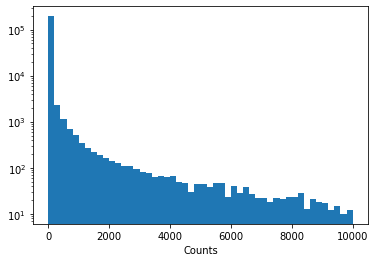

In [ ]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = {token:tokens.index(token) for token in tokens}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  861,    19,   505,  2839,   243,   105, 11249,  2433,    16,
             0],
        [  407,    65,   105,    44,   146,    69,   218,    14,  4393,
           371],
        [ 1704,    32,   432,    14,  7029,  1118,     8,     8,  6371,
          2876]], dtype=int32),
 'Log1pSalary': array([ 9.862718, 11.046133, 10.308986], dtype=float32),
 'Title': array([[20937,     1,     1,     1],
        [ 6951,   794,   371,    21],
        [ 1704,    32,     1,     1]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(TitleEncoder, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        out = self.dense(h)
        return out

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(128, 100, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.conv2 = nn.Conv1d(100, 80, kernel_size=3, padding=1)
        self.pool2 = GlobalMaxPooling()
        self.dense1 = nn.Linear(80, out_size)
        self.dense2 = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        h = torch.transpose(h, 1, 2)
        h = F.max_pool1d(self.conv1(h), 3)
        h = self.pool2(self.conv2(h))
        h = self.dense1(F.relu(h))
        out = self.dense2(F.relu(h))
        return out

In [ ]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
                              nn.Linear(n_cat_features, 512),
                              nn.ReLU(),
                              nn.Linear(512, 256),
                              nn.ReLU(),
                              nn.Linear(256, 64)
                              )
        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Sequential(nn.Linear(64 * 3, 128),
                                 nn.BatchNorm1d(128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 1))
  
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.out(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	22.20076
	MAE:	30334.03595



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.37788
	MAE:	54159.01154



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.30687
	MAE:	16913.98569



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.22455
	MAE:	9001.68487



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.11465
	MAE:	12958.47688



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.77983
	MAE:	10576.11926



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.02812
	MAE:	12837.85176



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.54288
	MAE:	10192.36680



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.91672
	MAE:	11353.94194



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.00097
	MAE:	17523.04094



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.83716
	MAE:	10713.83140



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.77993
	MAE:	13488.79194



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.79729
	MAE:	10207.16760



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.75403
	MAE:	8734.21552



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.74270
	MAE:	9911.07414



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.61518
	MAE:	11281.31476



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.66222
	MAE:	9291.07873



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.96189
	MAE:	6774.46930



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.60663
	MAE:	8623.89264



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.98773
	MAE:	7980.91318



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.61970
	MAE:	8787.26668



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.50869
	MAE:	9079.08522



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.55325
	MAE:	8253.00823



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.45302
	MAE:	8236.82746



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.53655
	MAE:	7919.13840



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.48332
	MAE:	8916.50777



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.47239
	MAE:	7263.06573



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.40166
	MAE:	7673.18037



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.49532
	MAE:	7634.14987



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46018
	MAE:	5575.67270



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.45913
	MAE:	7269.90718



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.58728
	MAE:	11872.74928



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.49500
	MAE:	7455.86123



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35155
	MAE:	5960.74303



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.44821
	MAE:	7281.49797



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.51857
	MAE:	9632.28154



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.43265
	MAE:	6875.79055



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.41973
	MAE:	8364.42477



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.40318
	MAE:	6709.92656



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.37405
	MAE:	5339.36491



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.39049
	MAE:	6514.12613



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25876
	MAE:	4914.81125





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

1. Did own torch dataset and dataloader.
2. In collate function made variable-sized batches based on max len of sequence in batch for Description data. 
3. For Title data made constant len for sequences as a median of all titles' lengths.
4. NN for title data consists of embedding part, several convolutional layers with different kernel sizes (2,3,4), max pool layer and concatenation to one tensor + 2 linear layers with one ReLU inbetween at the end.
5. NN for description data consists of embedding part, simple two-layered LSTM with convolutional and maxpool layers on top + one linear layer.
6. NN for categorical data consists of simple NN with 3 linear layers and ReLU inbetween.
7. After concatenating all of these outputs added linear layers with batchnorm and dropouts.
8. In training part added early stopper, MAE and loss plot tracker, loss scheduler and model backup to local.
---
Result:  
Best MAE = 2745.94 on validation data. (Since it is 3464 in Kaggle leaderboards, I think this is a good result).

#Solution

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import time
import tqdm
from copy import deepcopy
from torch.optim.lr_scheduler import ReduceLROnPlateau

Some of previous code

In [ ]:
import nltk
from collections import Counter

#unify everything
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row, value in data[['Title', 'FullDescription']].iterrows():
  text = ' '.join((value['Title'], value['FullDescription'])).split(' ')
  for word in text:
    token_counts[word] += 1

min_count = 10
# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {token:tokens.index(token) for token in tokens} # aka our vocabulary

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")
categorical_columns = ["Category", 
                      "Company", 
                      "LocationNormalized", 
                      "ContractType", 
                      "ContractTime"]
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [ ]:
#decided to use categorical features from outside
cat_vector = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

## My dataset

In [ ]:
class TDCDataset(Dataset): # TDC for Title, Description and Categorical
    def __init__(self, data, vocab, categories, transform=False):
        # main info
        self.data = data 
        self.vocab = vocab
        self.cats = categories
        self.transform = transform # for future use
        # dealing with unknown and padding tokens
        self.UNK, self.PAD = "UNK", "PAD"
        self.UNK_IX = self.vocab.get(self.UNK)
        self.PAD_IX = self.vocab.get(self.PAD)
        # dealing with column names
        self.title_column = "Title"
        self.desc_column = "FullDescription"
        self.target_column = "Log1pSalary"
        # using median as a size of title column
        self.title_len = int(self.data[self.title_column].str.split(' ').str.len().median())

    def _token2id(self, row, col, defined_len=None):
        data = row[col].values[0].split(' ')
        if defined_len:
            if defined_len <= len(data):
                data = data[:defined_len]
            else:
                data +=  [self.PAD] * (defined_len - len(data))
        return [self.vocab.get(word, self.UNK_IX) for word in data]
    
    def __getitem__(self, index: int):
        row = self.data.iloc[[index]]
        title = torch.LongTensor([self._token2id(row, self.title_column, self.title_len)])
        desc = torch.LongTensor([self._token2id(row, self.desc_column)])
        cat = torch.FloatTensor([self.cats[index]])
        target = torch.FloatTensor([row[self.target_column].values])

        return {'title': title, 
                'description': desc,
                'categorical_features': cat, 
                'target': target}
      
    def __len__(self):
        return len(self.data)

In [ ]:
dataset = TDCDataset(data, token_to_id, cat_vector)

In [ ]:
[dataset[i] for i in range(3)]

[{'categorical_features': tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
  'description': tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5, 15,  6, 16, 17,
           18, 19,  2,  3,  4, 10, 11, 20, 21, 22, 23, 24, 25, 26, 15, 27, 28, 15,
           29, 26, 15, 30, 15,  0, 15,  0,  2,  3,  4,  5,  6,  7,  8,  9]]),
  'target': tensor([[10.1267]]),
  'title': tensor([[2, 3, 4, 1]])},
 {'categorical_features': tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
  'description': tensor([[ 31,  32,  33,   7,   8,  34,   8,  35,  36,  37,  18,  19,  38,  39,
            34,  40,  10,  41,  33,  42,  43,  44,  45,  46,  47,  48,  49,  50,
            17,  51,  52,  34,  53,  54,   2,  55,  56,  57,  58,  46,  59,  60,
            15,  61,  62,  35,  63,  64,  65,  49,  66,  34,  67,  68,  69,  70,
            34,  71,  53,  72,  73,  34,  10,  74,  75,  15,  76,  77,  78,  16,
            79,  48,  14,  80,  15,  65,  63,  81,  82,  83,  84,  16,  49,  85,
            19,  86,  16,  87,  16,

### Dividing into train/val

In [ ]:
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, 
                                                          [train_size, val_size],
                                                          generator=torch.Generator().manual_seed(42))

### Collator
collator is needed for using with RNNs 

In [ ]:
from collections import defaultdict
from typing import List

def collate_fn(dataset_items: List[dict]):
    result_batch = defaultdict(list)
    for batch in dataset_items:
        for feature, data in batch.items():
            if feature == 'description':
               result_batch[feature + '_length'].append(torch.tensor([data.size(-1)]))
            result_batch[feature].append(data.squeeze(0).transpose(0, -1))
    # pad
    for feature, data in result_batch.items():
        result_batch[feature] = nn.utils.rnn.pad_sequence(data, True, token_to_id['PAD'])
        if result_batch[feature].size(-1) == 1:
            result_batch[feature] = result_batch[feature].squeeze(-1)
    return result_batch

In [ ]:
collate_fn([dataset[i] for i in range(3)])

defaultdict(list,
            {'categorical_features': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
                     [0., 0., 0.,  ..., 0., 0., 0.],
                     [0., 0., 0.,  ..., 0., 0., 0.]]),
             'description': tensor([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,   5,
                       15,   6,  16,  17,  18,  19,   2,   3,   4,  10,  11,  20,  21,  22,
                       23,  24,  25,  26,  15,  27,  28,  15,  29,  26,  15,  30,  15,   0,
                       15,   0,   2,   3,   4,   5,   6,   7,   8,   9,   1,   1,   1,   1,
                        1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                        1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                        1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                        1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                        1,   1,   1,   1,   1,

### Dataloader

In [ ]:
batch_size = 64
dataset_dict = {
    'train': train_dataset,
    'val': val_dataset
}

In [ ]:
dataloaders_dict = {x: DataLoader(dataset_dict[x], 
                                  batch_size=batch_size, 
                                  shuffle=True,
                                  collate_fn=collate_fn,
                                  num_workers=4,
                                  pin_memory=True) 
                                  for x in dataset_dict.keys()}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# check sizes
for i, batch in enumerate(dataloaders_dict['train']):
  for feature, val in batch.items():
    print(feature,'\n\t', val.size())
  if i == 2:
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


title 
	 torch.Size([64, 4])
description_length 
	 torch.Size([64])
description 
	 torch.Size([64, 834])
categorical_features 
	 torch.Size([64, 3768])
target 
	 torch.Size([64])
title 
	 torch.Size([64, 4])
description_length 
	 torch.Size([64])
description 
	 torch.Size([64, 868])
categorical_features 
	 torch.Size([64, 3768])
target 
	 torch.Size([64])
title 
	 torch.Size([64, 4])
description_length 
	 torch.Size([64])
description 
	 torch.Size([64, 727])
categorical_features 
	 torch.Size([64, 3768])
target 
	 torch.Size([64])


## Model itself

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Title

In [ ]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncodingParams:
  # embeddings parameters
  num_tokens = len(tokens)
  embedding_size = 64
  PAD_IDX = token_to_id['PAD']

  # convolution parameters
  seq_len = 4
  stride = 1
  hidden_size_conv = 32

  # dense parameters
  hidden_size_dense = 64
  out_size = 64

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, params):
        """ 
        Convolutional encoder with two kernel sizes 2, 3, and 4 with linear layer at the end.
        Based on 
        https://aclanthology.org/D14-1181.pdf and https://lena-voita.github.io/nlp_course/models/convolutional.html
        """
        super(TitleEncoder, self).__init__()
        
        # Embeddings parameters
        self.num_tokens = params.num_tokens
        self.embedding_size = params.embedding_size
        self.PAD_IDX = params.PAD_IDX

        # Embedding definition
        self.emb = nn.Embedding(self.num_tokens, self.embedding_size, padding_idx=self.PAD_IDX)

        # Convolution parameters
        self.kernel1 = 2
        self.kernel2 = 3
        self.kernel3 = 4
        # self.kernel4 = 5
        self.stride = params.stride
        self.hidden_size_1 = params.hidden_size_conv
        self.seq_len = params.seq_len

        # Convolution definition
        self.conv1 = nn.Conv1d(self.embedding_size, self.hidden_size_1, self.kernel1, self.stride)
        self.conv2 = nn.Conv1d(self.embedding_size, self.hidden_size_1, self.kernel2, self.stride)
        self.conv3 = nn.Conv1d(self.embedding_size, self.hidden_size_1, self.kernel3, self.stride)

        # Global Max pooling definition
        self.pool1 = GlobalMaxPooling()        
        self.pool2 = GlobalMaxPooling()        
        self.pool3 = GlobalMaxPooling()        
        # self.pool4 = GlobalMaxPooling()        

        # FC parameters
        self.hidden_size_2 = params.hidden_size_dense
        self.out_size = params.out_size

        # FC definition
        self.fc1 = nn.Linear(self.hidden_size_1*3, self.hidden_size_2)
        self.out = nn.Linear(self.hidden_size_2, self.out_size)

        # Additional functions
        # self.dropout = nn.Dropout(0.2)
        # self.bn = nn.BatchNorm1d(self.hidden_size_2)


    def forward(self, text_ix):
      x1 = self.emb(text_ix)
      x1 = torch.transpose(x1, 1, 2)
      x1 = self.pool1(self.conv1(x1))
      x1 = F.relu(x1)

      x2 = self.emb(text_ix)
      x2 = torch.transpose(x2, 1, 2)
      x2 = self.pool2(self.conv2(x2))
      x2 = F.relu(x2)

      x3 = self.emb(text_ix)
      x3 = torch.transpose(x3, 1, 2)
      x3 = self.pool3(self.conv3(x3))
      x3 = F.relu(x3)

      # x4 = self.emb(text_ix)
      # x4 = self.pool4(self.conv4(x4))
      # x4 = F.relu(x4)

      x = torch.cat([x1, x2, x3], 1)

      x = F.relu(self.fc1(x))

      x = self.out(x)

      return x

In [ ]:
title_encoder = TitleEncoder(TitleEncodingParams)
dummy_x = next(iter(dataloaders_dict['train']))['title']
dummy_v = title_encoder(dummy_x)

print(dummy_v.shape)

del title_encoder
print("Seems fine")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 64])
Seems fine


### Description

In [ ]:
class DescEncodingParams:
  # embeddings parameters
  num_tokens = len(tokens)
  embedding_size = 64
  PAD_IDX = token_to_id['PAD']

  # rnn parameters
  batch_size = batch_size
  hidden_size = 128
  n_layers = 2
  bidir = False

  # convolution parameters
  seq_len = 200
  stride = 1
  hidden_size_conv = 64
  kernel_size = 1
  
  # dense parameters
  hidden_size_dense = 64
  out_size = 64

In [ ]:
class DescEncoder(nn.Module):
  def __init__(self, params):
    super(DescEncoder, self).__init__()

    # Embeddings parameters
    self.num_tokens = params.num_tokens
    self.embedding_size = params.embedding_size
    self.PAD_IDX = params.PAD_IDX

    # Embedding definition
    self.emb = nn.Embedding(self.num_tokens, 
                            self.embedding_size, 
                            padding_idx=self.PAD_IDX)

    # LSTM parameters
    self.hidden_size = params.hidden_size
    self.n_layers = params.n_layers
    self.bidir = params.bidir
    # LSTM definition
    self.lstm = nn.LSTM(self.embedding_size, 
                        self.hidden_size, 
                        self.n_layers, 
                        batch_first=True, 
                        bidirectional=self.bidir)
    
    self.pool = GlobalMaxPooling()   

    # Convolution parameters
    self.kernel = params.kernel_size
    self.stride = params.stride
    self.hidden_size_conv = params.hidden_size_conv
    self.seq_len = params.seq_len
    self.batch_size = params.batch_size

    # Convolution definition
    self.conv1 = nn.Conv1d(self.hidden_size, self.hidden_size_conv, self.kernel, self.stride)

    # FC parameters
    self.out_size = params.out_size
    # FC definition
    self.out = nn.Linear(self.hidden_size_conv, self.out_size)

  def forward(self, x, lengths):
    x = self.emb(x)
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths.cpu(), batch_first=True, enforce_sorted=False)
    x_packed, (fhs, fcs) = self.lstm(x_packed)
    x, _ = torch.nn.utils.rnn.pad_packed_sequence(x_packed)
    x = x.permute(1, 2, 0)
    x = self.pool(self.conv1(x))
    x = self.out(x)
    return x

In [ ]:
desc_encoder = DescEncoder(DescEncodingParams)
dummy_x = batch['description']
dummy_y = batch['description_length']
dummy_v = desc_encoder(dummy_x, dummy_y)
print(dummy_v.shape)
del desc_encoder

torch.Size([64, 64])


### Alltogether

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, DescParams, TitleParams, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(TitleParams)
        self.desc_encoder = DescEncoder(DescParams)
        assert DescParams.out_size == TitleParams.out_size
        self.cat_encoder = nn.Sequential(
                              nn.Linear(n_cat_features, 256),
                              nn.ReLU(),
                              nn.Linear(256, 256),
                              nn.ReLU(),
                              nn.Linear(256, DescParams.out_size)
                              )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Sequential(nn.Linear(DescParams.out_size * 3, 128),
                                 nn.BatchNorm1d(128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128, 64),
                                 nn.BatchNorm1d(64),
                                 nn.ReLU(),
                                 nn.Linear(64, 1))
  
        
    def forward(self, title_ix, desc_ix, desc_len, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix, desc_len)
        cat_h = self.cat_encoder(cat_features)
        
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        out = self.out(joint_h)
        
        return out[:, 0]
    
    def count_parameters(self):
      temp = sum(p.numel() for p in self.parameters() if p.requires_grad)
      print(f'The model architecture:\n\n', self)
      print(f'\nThe model has {temp:,} trainable parameters')

In [ ]:
model = FullNetwork(DescEncodingParams, TitleEncodingParams)
model = model.to(device)
model.count_parameters()

The model architecture:

 FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(34158, 64, padding_idx=1)
    (conv1): Conv1d(64, 32, kernel_size=(2,), stride=(1,))
    (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (conv3): Conv1d(64, 32, kernel_size=(4,), stride=(1,))
    (pool1): GlobalMaxPooling()
    (pool2): GlobalMaxPooling()
    (pool3): GlobalMaxPooling()
    (fc1): Linear(in_features=96, out_features=64, bias=True)
    (out): Linear(in_features=64, out_features=64, bias=True)
  )
  (desc_encoder): DescEncoder(
    (emb): Embedding(34158, 64, padding_idx=1)
    (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
    (pool): GlobalMaxPooling()
    (conv1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (out): Linear(in_features=64, out_features=64, bias=True)
  )
  (cat_encoder): Sequential(
    (0): Linear(in_features=3768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
 

## Train

Supplementary functions

In [ ]:
def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
def save_checkpoint(model, optimizer, epoch, val_loss, save_path='model1.pt'):
    state_dict = {'epoch':epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

In [ ]:
def plot_stats(scores, losses):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5*2, 5))
  ax1.plot(losses)
  ax2.plot(scores)
  ax1.set_title('Losses curve')
  ax2.set_title('Score curve')
  ax1.grid()
  ax2.grid()
  plt.show()

In [ ]:
def train(model, 
          criterion, 
          dataloaders, 
          optimizer, 
          num_epochs=20, 
          early_stop = 5,
          scheduler=None):
    since = time.time()

    min_mae = float("inf")
    early_stop_counter = 0
    val_mae_history = []
    val_loss_history = []

    best_model_wts = deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
              model.train()
            else:
              model.eval()
            
            running_loss = 0.0
            running_mae = 0.0

            for batch in tqdm.tqdm(dataloaders_dict[phase]):
                title = batch['title'].to(device)
                desc = batch['description'].to(device)
                desc_len = batch['description_length'].to(device)
                cats = batch['categorical_features'].to(device)
                target = batch['target'].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    output = model(title, desc, desc_len, cats)
                    loss = criterion(output, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_mae += compute_mae(output, target).item()
            epoch_loss = running_loss / len(dataloaders_dict[phase])
            epoch_mae = running_mae / len(dataloaders_dict[phase])

            print('{} Loss: {:.4f} MAE: {:.4f}'.format(phase, epoch_loss, epoch_mae))

            # deep copy the model if it is good
            if phase == 'val':
                if epoch_mae < min_mae:
                    best_model_wts = deepcopy(model.state_dict())
                    min_mae = epoch_mae
                    # saving best model to local
                    save_checkpoint(model, optimizer, epoch, epoch_loss)
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                val_mae_history.append(epoch_mae)
                val_loss_history.append(epoch_loss)
        plot_stats(val_mae_history, val_loss_history)

        # scheduler
        if scheduler is not None:
          scheduler.step(epoch_loss)
          
        # early stop
        if early_stop_counter == early_stop:
          print('Oops, early stop! Exiting...\n')
          break


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val MAE: {:4f}'.format(min(val_mae_history)))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_mae_history, val_loss_history

In [ ]:
criterion = nn.MSELoss()
num_epochs = 30
learning_rate = 0.001
wd = 0.001
early_stop = 5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
sched = ReduceLROnPlateau(optimizer, 'min', patience=3)

Epoch 1/30
----------


  0%|          | 0/3443 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 3443/3443 [12:18<00:00,  4.67it/s]


train Loss: 3.3737 MAE: 4892.0882


100%|██████████| 383/383 [00:40<00:00,  9.40it/s]


val Loss: 0.2112 MAE: 4383.5892
Model saved to ==> model1.pt


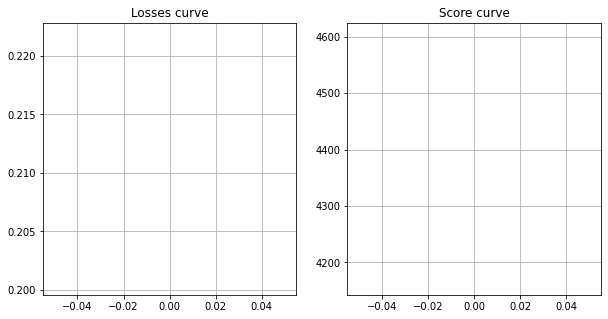

Epoch 2/30
----------


100%|██████████| 3443/3443 [12:20<00:00,  4.65it/s]


train Loss: 0.1332 MAE: 3500.9416


100%|██████████| 383/383 [00:40<00:00,  9.47it/s]


val Loss: 0.6934 MAE: 7155.9019


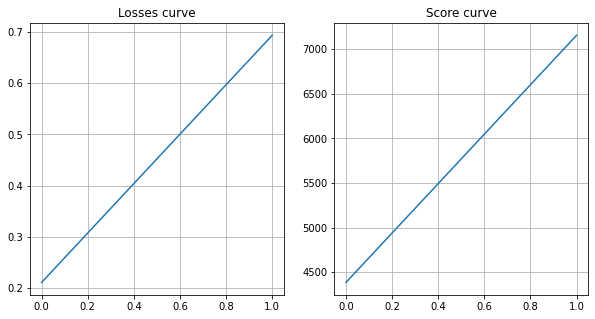

Epoch 3/30
----------


100%|██████████| 3443/3443 [12:24<00:00,  4.63it/s]


train Loss: 0.1156 MAE: 3269.2209


100%|██████████| 383/383 [00:40<00:00,  9.40it/s]


val Loss: 0.1820 MAE: 3987.3067
Model saved to ==> model1.pt


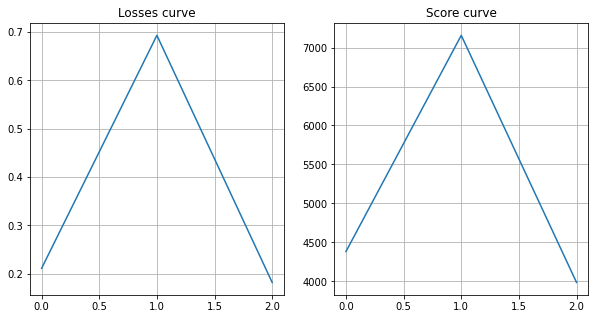

Epoch 4/30
----------


100%|██████████| 3443/3443 [12:25<00:00,  4.62it/s]


train Loss: 0.1071 MAE: 3139.6199


100%|██████████| 383/383 [00:40<00:00,  9.42it/s]


val Loss: 0.1125 MAE: 3269.4845
Model saved to ==> model1.pt


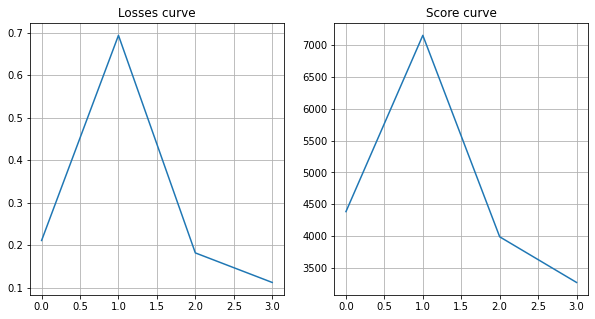

Epoch 5/30
----------


100%|██████████| 3443/3443 [12:28<00:00,  4.60it/s]


train Loss: 0.1026 MAE: 3078.5660


100%|██████████| 383/383 [00:40<00:00,  9.35it/s]


val Loss: 0.1385 MAE: 3569.1429


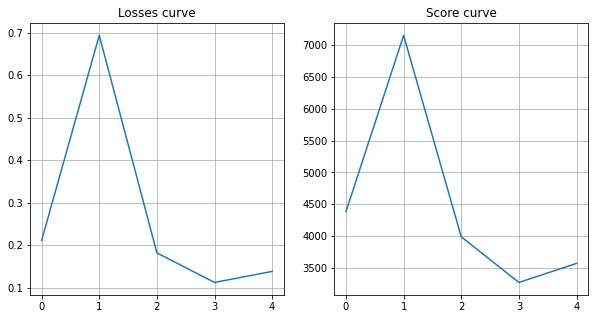

Epoch 6/30
----------


100%|██████████| 3443/3443 [12:26<00:00,  4.61it/s]


train Loss: 0.0969 MAE: 2985.8169


100%|██████████| 383/383 [00:41<00:00,  9.21it/s]


val Loss: 0.1930 MAE: 4129.6949


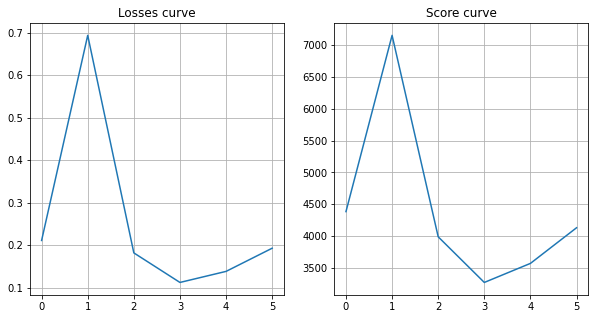

Epoch 7/30
----------


100%|██████████| 3443/3443 [12:25<00:00,  4.62it/s]


train Loss: 0.0945 MAE: 2942.3461


100%|██████████| 383/383 [00:41<00:00,  9.21it/s]


val Loss: 0.1202 MAE: 3280.3122


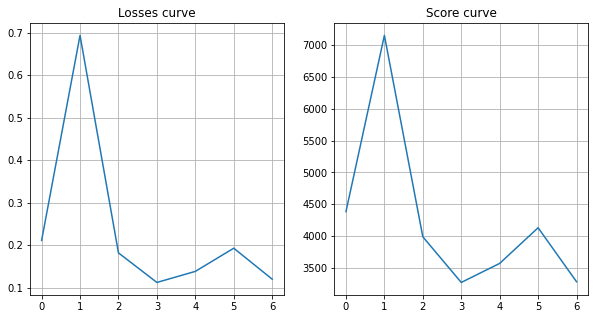

Epoch 8/30
----------


100%|██████████| 3443/3443 [12:25<00:00,  4.62it/s]


train Loss: 0.0922 MAE: 2905.4696


100%|██████████| 383/383 [00:43<00:00,  8.90it/s]


val Loss: 0.0808 MAE: 2720.6702
Model saved to ==> model1.pt


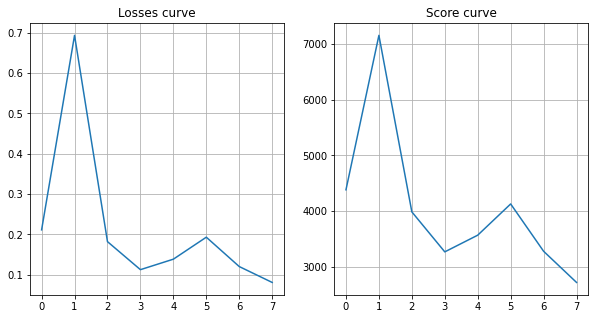

Epoch 9/30
----------


100%|██████████| 3443/3443 [12:28<00:00,  4.60it/s]


train Loss: 0.0902 MAE: 2864.8349


100%|██████████| 383/383 [00:42<00:00,  8.91it/s]


val Loss: 0.0948 MAE: 2971.7337


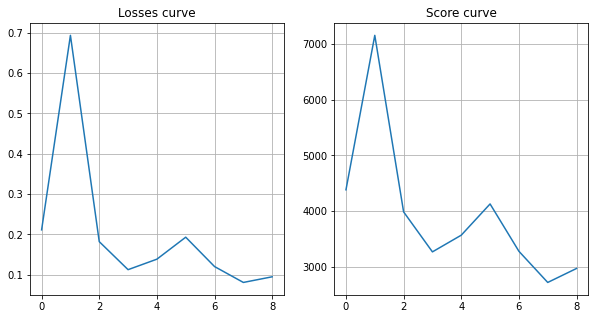

Epoch 10/30
----------


100%|██████████| 3443/3443 [12:32<00:00,  4.57it/s]


train Loss: 0.0889 MAE: 2844.5244


100%|██████████| 383/383 [00:43<00:00,  8.83it/s]


val Loss: 0.0964 MAE: 3010.5152


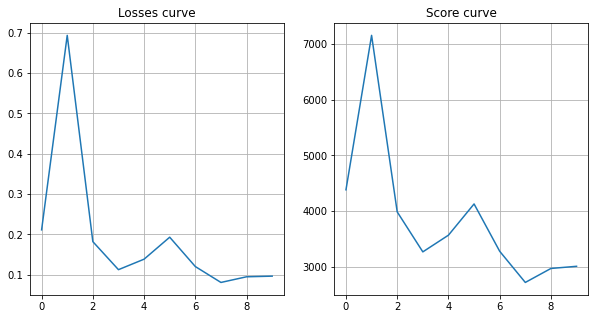

Epoch 11/30
----------


100%|██████████| 3443/3443 [12:32<00:00,  4.57it/s]


train Loss: 0.0866 MAE: 2795.7797


100%|██████████| 383/383 [00:43<00:00,  8.76it/s]


val Loss: 0.0885 MAE: 2889.5870


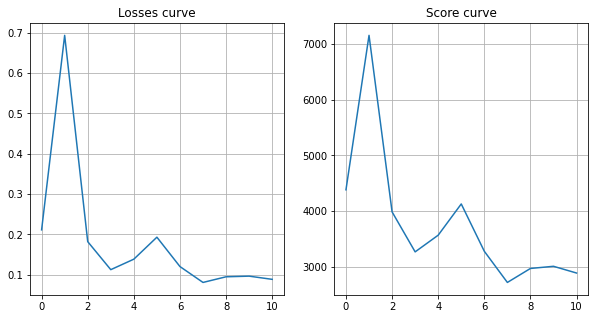

Epoch 12/30
----------


100%|██████████| 3443/3443 [12:32<00:00,  4.57it/s]


train Loss: 0.0855 MAE: 2776.7813


100%|██████████| 383/383 [00:44<00:00,  8.67it/s]


val Loss: 0.0829 MAE: 2781.1127


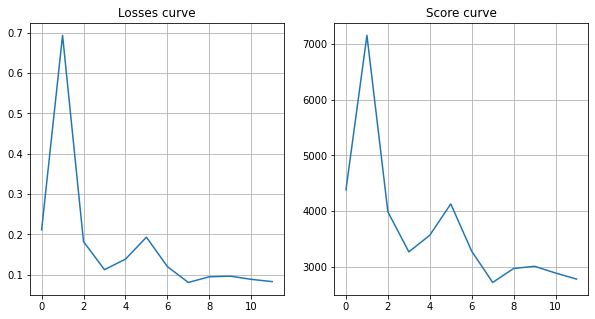

Epoch 13/30
----------


100%|██████████| 3443/3443 [12:34<00:00,  4.56it/s]


train Loss: 0.0736 MAE: 2559.9717


100%|██████████| 383/383 [00:44<00:00,  8.69it/s]


val Loss: 0.0725 MAE: 2532.7792
Model saved to ==> model1.pt


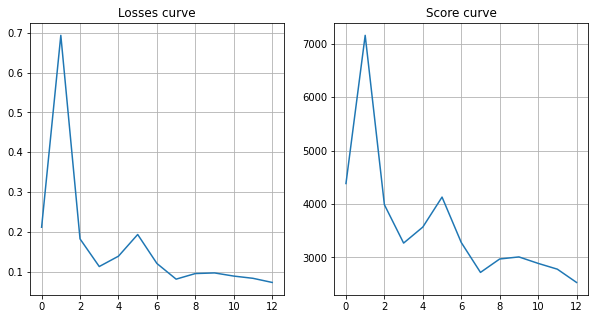

Epoch 14/30
----------


100%|██████████| 3443/3443 [12:32<00:00,  4.57it/s]


train Loss: 0.0701 MAE: 2490.0237


100%|██████████| 383/383 [00:44<00:00,  8.54it/s]


val Loss: 0.0710 MAE: 2489.8852
Model saved to ==> model1.pt


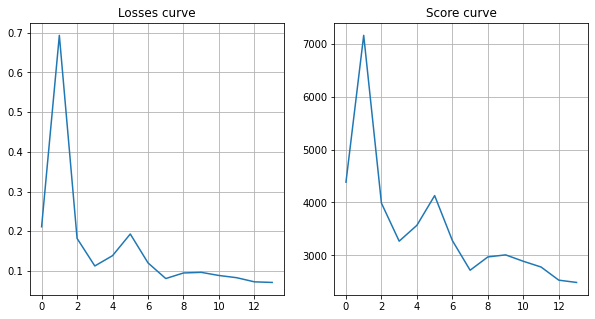

Epoch 15/30
----------


100%|██████████| 3443/3443 [12:29<00:00,  4.60it/s]


train Loss: 0.0682 MAE: 2460.1940


100%|██████████| 383/383 [00:44<00:00,  8.67it/s]


val Loss: 0.0682 MAE: 2444.2665
Model saved to ==> model1.pt


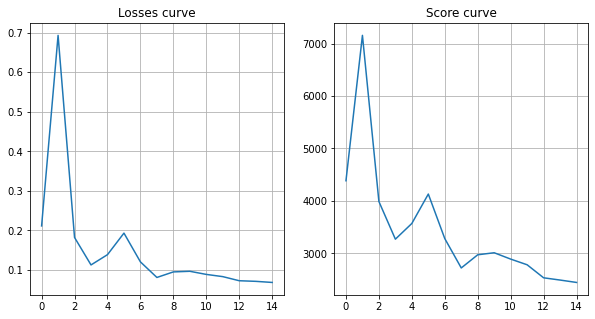

Epoch 16/30
----------


100%|██████████| 3443/3443 [12:33<00:00,  4.57it/s]


train Loss: 0.0663 MAE: 2424.8238


100%|██████████| 383/383 [00:44<00:00,  8.65it/s]


val Loss: 0.0686 MAE: 2454.3623


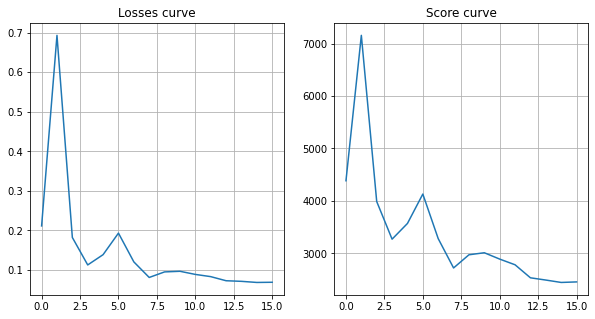

Epoch 17/30
----------


100%|██████████| 3443/3443 [12:35<00:00,  4.56it/s]


train Loss: 0.0649 MAE: 2399.7251


100%|██████████| 383/383 [00:44<00:00,  8.67it/s]


val Loss: 0.0718 MAE: 2511.3260


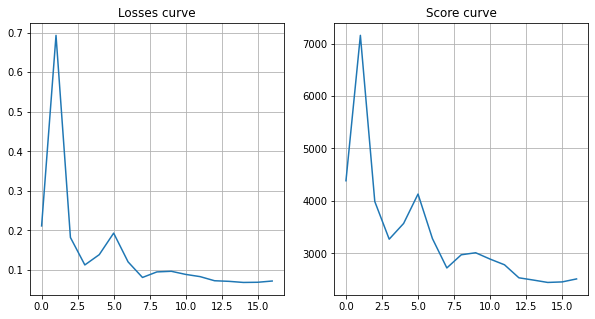

Epoch 18/30
----------


100%|██████████| 3443/3443 [12:35<00:00,  4.56it/s]


train Loss: 0.0637 MAE: 2379.7078


100%|██████████| 383/383 [00:44<00:00,  8.65it/s]


val Loss: 0.0672 MAE: 2422.5807
Model saved to ==> model1.pt


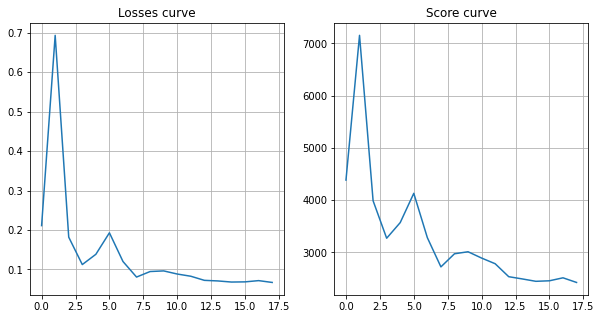

Epoch 19/30
----------


100%|██████████| 3443/3443 [12:25<00:00,  4.62it/s]


train Loss: 0.0621 MAE: 2348.1082


100%|██████████| 383/383 [00:43<00:00,  8.78it/s]


val Loss: 0.0668 MAE: 2404.8738
Model saved to ==> model1.pt


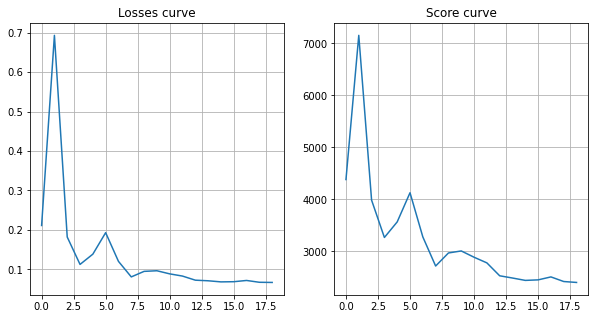

Epoch 20/30
----------


100%|██████████| 3443/3443 [12:24<00:00,  4.62it/s]


train Loss: 0.0612 MAE: 2330.8108


100%|██████████| 383/383 [00:43<00:00,  8.74it/s]


val Loss: 0.0683 MAE: 2438.9934


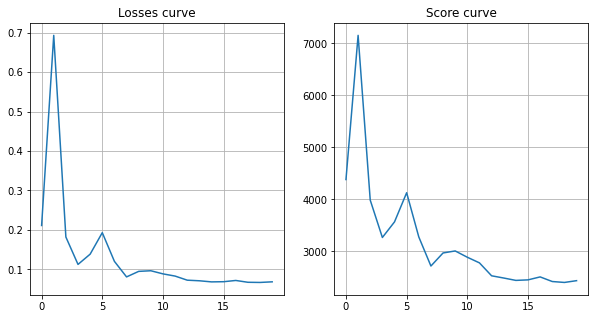

Epoch 21/30
----------


100%|██████████| 3443/3443 [12:22<00:00,  4.63it/s]


train Loss: 0.0603 MAE: 2314.1706


100%|██████████| 383/383 [00:44<00:00,  8.60it/s]


val Loss: 0.0668 MAE: 2401.7208
Model saved to ==> model1.pt


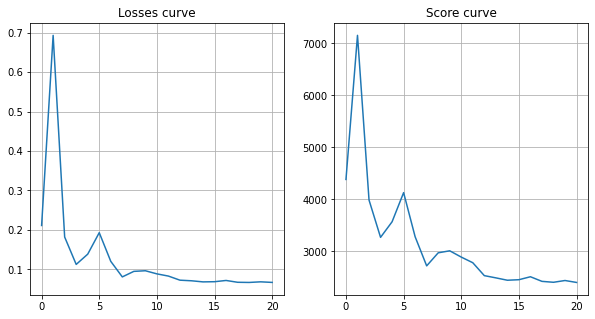

Epoch 22/30
----------


100%|██████████| 3443/3443 [12:22<00:00,  4.64it/s]


train Loss: 0.0595 MAE: 2302.2197


100%|██████████| 383/383 [00:44<00:00,  8.64it/s]


val Loss: 0.0658 MAE: 2384.8610
Model saved to ==> model1.pt


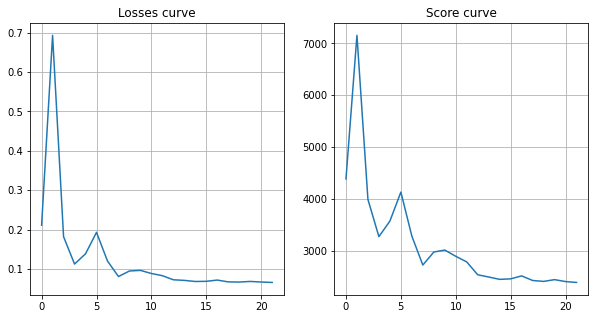

Epoch 23/30
----------


 69%|██████▉   | 2386/3443 [08:39<03:49,  4.60it/s]


KeyboardInterrupt: ignored

In [ ]:
model, maes, losses = train(model, 
                            criterion, 
                            dataloaders_dict, 
                            optimizer, 
                            num_epochs, 
                            early_stop,
                            scheduler=sched)